In [60]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim

In [71]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = ConcatDataset([datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)])

# Calculating mean and standard deviation for this dataset
mean = torch.zeros(3)
std = torch.zeros(3)
for img, _ in dataset:
  mean += img.mean([1,2])
  std += img.std([1,2])
mean /= len(dataset)
std /= len(dataset)

print(f"Mean: {mean}")
print(f"Standart Deviation: {std}")

# Reinitializing the dataset with normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean.tolist(), std=std.tolist())])
dataset = ConcatDataset([datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)])

Files already downloaded and verified
Mean: tensor([0.4914, 0.4822, 0.4465])
Standart Deviation: tensor([0.2023, 0.1994, 0.2010])


In [72]:
total_size = len(dataset)
train_size = int(total_size * 0.8)
test_size = int(total_size * 0.1)
val_size = total_size - train_size - test_size

trainset, testset, valset = random_split(dataset, [train_size, test_size, val_size])

batch_size = 2**7
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True) # to ensure that the model remains general and does not overfit to the specific sequence of data
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False)

In [73]:
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            # First Convolutional Layer (Input: 32x32x3, Output: 32x32x8)
            nn.Conv2d(3, 8, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # First Max Pooling (Output: 16x16x8)

            # Second Convolutional Layer (Output: 16x16x12)
            nn.Conv2d(8, 12, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Second Max Pooling (Output: 8x8x12)

            # Third Convolutional Layer (Output: 8x8x16)
            nn.Conv2d(12, 16, 3, stride=1, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            # First Upsampling (Input: 8x8x16, Output: 16x16x16)
            nn.ConvTranspose2d(16, 12, 2, stride=2),
            nn.ReLU(),

            # Fourth Convolutional Layer (Output: 16x16x12)
            nn.Conv2d(12, 12, 3, stride=1, padding=1),
            nn.ReLU(),

            # Second Upsampling (Output: 32x32x12)
            nn.ConvTranspose2d(12, 8, 2, stride=2),
            nn.ReLU(),

            # Fifth Convolutional Layer (Output: 32x32x3)
            nn.Conv2d(8, 3, 3, stride=1, padding=1),
            # nn.Sigmoid()  or nn.Tanh() # but the input images are not normalized between 0(-1) and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [74]:
# Initializing the model
model = ConvAutoencoder()

criterion = nn.MSELoss() # Loss function

optimizer = optim.Adam(model.parameters(), lr=0.001)

if torch.cuda.is_available():
    model = model.cuda()

In [76]:
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        if torch.cuda.is_available():
            inputs = inputs.cuda()

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}')

    # Validation
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, _ in val_loader:
            if torch.cuda.is_available():
                inputs = inputs.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            validation_loss += loss.item()

        validation_loss /= len(val_loader)
        val_losses.append(validation_loss)
        print(f'Validation Loss after epoch {epoch+1}: {validation_loss:.4f}')

Epoch [1/10], Training Loss: 0.2919
Validation Loss after epoch 1: 0.2866
Epoch [2/10], Training Loss: 0.2833
Validation Loss after epoch 2: 0.2780
Epoch [3/10], Training Loss: 0.2747
Validation Loss after epoch 3: 0.2718
Epoch [4/10], Training Loss: 0.2592
Validation Loss after epoch 4: 0.2399
Epoch [5/10], Training Loss: 0.2282
Validation Loss after epoch 5: 0.2134
Epoch [6/10], Training Loss: 0.2115
Validation Loss after epoch 6: 0.2038
Epoch [7/10], Training Loss: 0.2021
Validation Loss after epoch 7: 0.1975
Epoch [8/10], Training Loss: 0.1988
Validation Loss after epoch 8: 0.1928
Epoch [9/10], Training Loss: 0.1920
Validation Loss after epoch 9: 0.1884
Epoch [10/10], Training Loss: 0.1886
Validation Loss after epoch 10: 0.1842


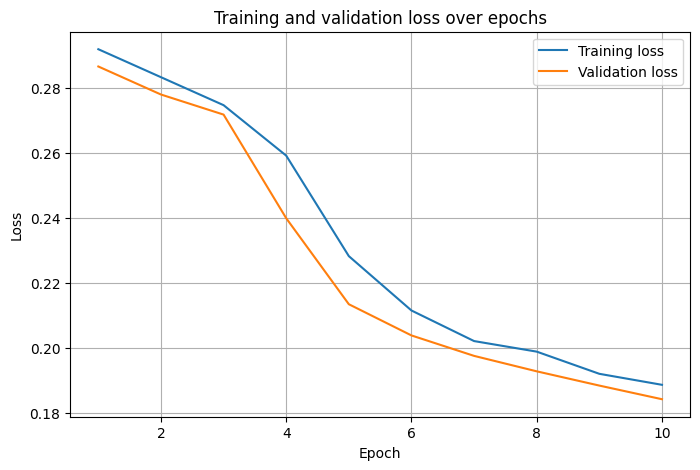

In [81]:
import matplotlib.pyplot as plt

epochs = range(1, 11)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, val_losses, label='Validation loss')
plt.title('Training and validation loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [82]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, _ in test_loader:
        if torch.cuda.is_available():
            inputs = inputs.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.1859


In [80]:
# Exercise 2 (a)

LSR_volume = 16
LSR_kernel = 3
LSR_padding = 1
LSR_stride = 1
LSR_channels = 16

LSR_size = LSR_channels * ((LSR_volume - LSR_kernel + 2 * LSR_padding) / LSR_stride + 1) ** 2
print(f'Size of Latent Space Representation is {int(LSR_size)}')

Size of LSR is 4096
